## Q-4 Implementation of Neural Network From Scratch. This class takes in list of Layer objects. It also takes a loss object. You can also allow it to take a seed as input. The seed is used for reproduciblity across runs. Each layer is characterized by its activation function and count of output neuron. Examples of activation include linear (W x + b), sigmoid, tanh etc.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [2]:
# Base class acts like Abstract Data Type for Layer class which acts as template to work with other class 
# It behave as parent class .
class LAYER:

    def Forward_Propagation(self, input):
        raise NotImplementedError
    
    def Backward_Propagation(self, output_error, learning_rate):
        raise NotImplementedError
        

In [3]:
# Inherit from parent class LAYER
class FBLAYER(LAYER):
    # input_length = Number of input neurons
    # output_length = Number of output neurons
    def __init__(self, input_length, output_length):
        self.weights = np.random.rand(input_length, output_length) - 0.5
        self.bias = np.random.rand(1, output_length) - 0.5

    # return output form a given (input data) X
    def Forward_Propagation(self, X):
        self.input = X
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # Computeing dE/dW, dE/dB for a given output_error = dE/dY. Return input_error = dE/dX.
    def Backward_Propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
    
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [4]:
class ActivationfunctionLayer(LAYER):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def Forward_Propagation(self, X):
        self.input = X
        self.output = self.activation(self.input)
        return self.output

    def Backward_Propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [5]:
# activation classes and its derivatives
class Activation_functions:
    def tanh(self,x):
        return np.tanh(x)

    def tanh_prime(self,x):
        return 1-np.tanh(x)**2

    def sigmoid(self,x):
        return 1/(1+np.exp(-x))

    def sigmoid_prime(self,x):
        s = self.sigmoid(x)
        return s*(1-s) 

    def linear(self,x):
        return x

    def linear_prime(self,x):
        return np.ones(x.shape)
    
    def softmax(self,x):
        a = np.exp(x)
        return a / np.sum(a)
       
    def softmax_prime(self,x):
        s = self.softmax(x)
        return s - s*s

In [6]:
# loss classes and its respective derivative

class mean_squared_error:
    
    def mse(self,y_true, y_pred):
        return np.mean(np.power(y_true-y_pred, 2))

    def mse_prime(self,y_true, y_pred):
        return 2*(y_pred-y_true)/y_true.size

class cross_entropy:

    def cross_en_prime(self,y_true, y_pred):
        
        # if value is negative than I will return 0.00000001
        y_pred[y_pred < 1e-8] = 1e-8
        lossGrad = (-1/(float(y_pred.shape[0])))*y_true*(1/y_pred)
        return lossGrad

    def cross_en(self,y_true,y_pred):
        y_pred[y_pred < 1e-8] = 1e-8
        loss= -np.sum(y_true*np.log(y_pred))
        return loss/float(y_pred.shape[0])


In [7]:
class Neural_Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # used to add layer to network
    def addition_of_layer(self, layer):
        self.layers.append(layer)

    # used to add the loss function
    def loss_useful_function(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict Output for given input
    def predict(self, X_test):
        result = []

        # forward propagation
        for i in range(len(X_test)):    
            Outpot = X_test[i]
            for layer in self.layers:
                Outpot = layer.Forward_Propagation(Outpot)
            result.append(Outpot)

        return result

    # training the Neural network
    def fit(self, x_train, y_train, iterations, learning_rate):

        lossStore = []
        # training the loop with given iterations
        for i in range(iterations):
            error = 0
            for j in range(len(x_train)):
                # forward propagation
                Outpot = x_train[j]
                for layer in self.layers:
                    Outpot = layer.Forward_Propagation(Outpot)

                # compute loss 
                error += self.loss(y_train[j], Outpot)
                
                # backward propagation
                error1 = self.loss_prime(y_train[j], Outpot)
                for layer in reversed(self.layers):
                    error1 = layer.Backward_Propagation(error1, learning_rate)

            # calculate average error on all samples
            error /= len(x_train)
            lossStore.append(error)
         
        return lossStore


## Q-5 (1) just one output neural with linear activation and least mean square loss (This is linear regression). Train this model on boston dataset using SGD.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

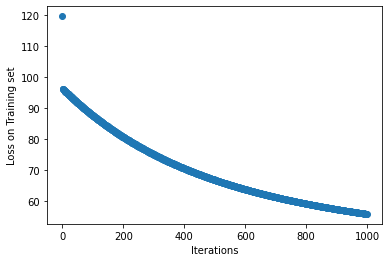

In [8]:
# Splitting the Data
x, y = load_boston(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

# Here we are scaling the data points
mean_of_X = np.mean(x_train)
max_value_twod_col = np.amax(x_train, axis = 0)
min_value_twod_col = np.amin(x_train, axis = 0)
x_train = (x_train- mean_of_X)/(max_value_twod_col - min_value_twod_col)
mean_of_X = np.mean(x_test)
max_value_twod_col = np.amax(x_test, axis = 0)
min_value_twod_col = np.amin(x_test, axis = 0)
x_test = (x_test- mean_of_X)/(max_value_twod_col - min_value_twod_col)

# Here we are expanding the dimension of input data into 3 dimensions 
x_train = np.expand_dims(x_train,axis=1)
y_train = y_train.reshape(y_train.shape[0],1)
y_train = np.expand_dims(y_train,axis=1)
x_test = np.expand_dims(x_test,axis=1)
y_test = y_test.reshape(y_test.shape[0],1)
y_test = np.expand_dims(y_test,axis=1)

# creating the Neural Network according to given question in Assignment
net1 = Neural_Network()
net1.addition_of_layer(FBLAYER(13, 1))
Activation_function = Activation_functions()
net1.addition_of_layer(ActivationfunctionLayer(Activation_function.linear, Activation_function.linear_prime))
lossfunction = mean_squared_error()
net1.loss_useful_function(lossfunction.mse, lossfunction.mse_prime)
lossStore = net1.fit(x_train, y_train,iterations = 1000, learning_rate=0.000004)

plt.scatter(range(len(lossStore)),lossStore)
plt.xlabel("Iterations")
plt.ylabel("Loss on Training set")
plt.show()

In [9]:
# testing the data point
y_pred = net1.predict(x_test)
print("Mean Squared error in Prediction of Housing Price   ",lossfunction.mse(y_pred,y_test))

Mean Squared error in Prediction of Housing Price    60.456795443854276


- We observe more error bcause we have only one neuron here

## Q-5(2) two layers. Layer 1 with 13 output neurons with sigmoid activation. Layer 2 with one output neuron and linear activation. use mean squared loss

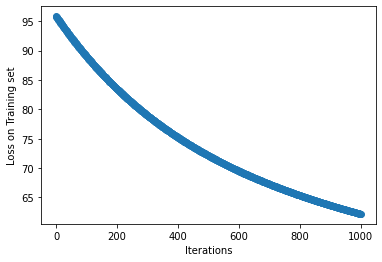

In [ ]:
# creating the Neural Network according to given question in Assignment
net2 = Neural_Network()
Activation_function = Activation_functions()
net2.addition_of_layer(FBLAYER(13, 13))
net2.addition_of_layer(ActivationfunctionLayer(Activation_function.sigmoid, Activation_function.sigmoid_prime))
net2.addition_of_layer(FBLAYER(13, 1))
net2.addition_of_layer(ActivationfunctionLayer(Activation_function.linear, Activation_function.linear_prime))
lossfunction = mean_squared_error()
net2.loss_useful_function(lossfunction.mse, lossfunction.mse_prime)
LossStore = net2.fit(x_train, y_train,iterations=1000, learning_rate=0.00004)

plt.scatter(range(len(lossStore)),lossStore)
plt.xlabel("Iterations")
plt.ylabel("Loss on Training set")
plt.show()

In [ ]:
# testing the x_trains values
y_pred = net2.predict(x_test)
print("Mean Squared error in Prediction of Housing Price   ",lossfunction.mse(y_pred,y_test))

Mean Squared error in Prediction of Housing Price    58.52995721528505


## Q-5(3) three layers. Layer 1 with 13 output neurons with sigmoid activation.Layer 2 with 13 output neurons and sigmoid activation. Layer 3 with oneoutput neuron and linear activation. use mean squared loss

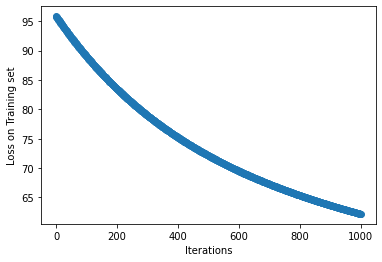

In [ ]:
# creating the Neural Network according to given question in Assignment
net3 = Neural_Network()
Activation_function = Activation_functions()
net3.addition_of_layer(FBLAYER(13, 13))
net3.addition_of_layer(ActivationfunctionLayer(Activation_function.sigmoid, Activation_function.sigmoid_prime))
net3.addition_of_layer(FBLAYER(13, 13))
net3.addition_of_layer(ActivationfunctionLayer(Activation_function.sigmoid, Activation_function.sigmoid_prime))
net3.addition_of_layer(FBLAYER(13, 1))
net3.addition_of_layer(ActivationfunctionLayer(Activation_function.linear, Activation_function.linear_prime))
lossfunction = mean_squared_error()
net3.loss_useful_function(lossfunction.mse, lossfunction.mse_prime)
LossStore = net3.fit(x_train, y_train,iterations = 1000, learning_rate=0.0004)

plt.scatter(range(len(lossStore)),lossStore)
plt.xlabel("Iterations")
plt.ylabel("Loss on Training set")
plt.show()

In [ ]:
# testing the x_trains values
y_pred = net3.predict(x_test)
print("Mean Squared error in Prediction of Housing Price   ",lossfunction.mse(y_pred,y_test))

Mean Squared error in Prediction of Housing Price    58.410121104970386


## Q-6 Using the above create following networks with the following
- two layers. Layer 1 with 89 output neurons with tanh activation. Layer 2 with ten output neuron and sigmoid activation. use mean squared loss by using Train this model on mnist (sklearn) dataset using SGD.

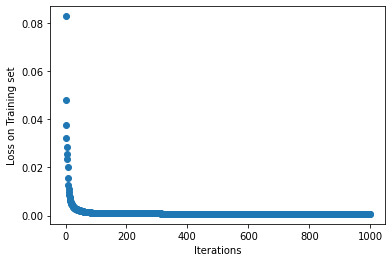

In [ ]:
# loading the  MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255

# it is used to convert the given number into list index of number (like if number is 8 than it put 1 at index 8 of list1  [0,0,0,0,0,0,0,0,1])
y_train = np_utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)

# creating the Neural Network according to given question in Assignment
net4 = Neural_Network()
Activation_function = Activation_functions()
net4.addition_of_layer(FBLAYER(28*28, 89))               
net4.addition_of_layer(ActivationfunctionLayer(Activation_function.tanh, Activation_function.tanh_prime))                                    
net4.addition_of_layer(FBLAYER(89, 10))                    
net4.addition_of_layer(ActivationfunctionLayer(Activation_function.sigmoid, Activation_function.sigmoid_prime))

# Here we are adding loss function 
lossfunction = mean_squared_error()
net4.loss_useful_function(lossfunction.mse, lossfunction.mse_prime)

# train on 1000 samples of data in network.
lossStore = net4.fit(x_train[0:1000], y_train[0:1000], iterations =1000, learning_rate=0.2)

plt.scatter(range(len(lossStore)),lossStore)
plt.xlabel("Iterations")
plt.ylabel("Loss on Training set")
plt.show()

In [ ]:
# testing on 100 data samples
out4 = net4.predict(x_test[0:100])
countPredictions=0
test_len = 100
for i in range(test_len):
    count=1;
    index = np.argmax(out4[i])
    if(index== np.argmax(y_test[i])):
        countPredictions+=1


print("Accuracy  ", (countPredictions/test_len)*100, "%")

Accuracy   90.0 %


- two layers. Layer 1 with 89 output neurons with tanh activation. Layer2 with ten output neuron and linear activation. use softmax with cross entropy loss.By using this model on mnist (sklearn) dataset using SGD.

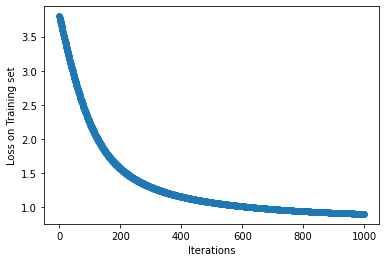

In [ ]:
# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
x_train = x_train 
y_train = np_utils.to_categorical(y_train)

# reshape and normalize testing data
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
x_train = x_train 
# it is used to convert the given number into list index of number like if number is 8 than it put 1 at index 8 of list1  [0,0,0,0,0,0,0,0,1]
y_test = np_utils.to_categorical(y_test)

# creating the Neural Network according to given question in Assignment
net5 = Neural_Network()
Activation_function = Activation_functions()
net5.addition_of_layer(FBLAYER(28*28, 89))               
net5.addition_of_layer(ActivationfunctionLayer(Activation_function.tanh, Activation_function.tanh_prime))                   
net5.addition_of_layer(FBLAYER(89, 10))                    
net5.addition_of_layer(ActivationfunctionLayer(Activation_function.softmax, Activation_function.softmax_prime))

# Here we are adding loss function 
lossfunction= cross_entropy()
net5.loss_useful_function(lossfunction.cross_en, lossfunction.cross_en_prime)

# train on 1000 samples of data in network
lossStore = net5.fit(x_train[0:1000], y_train[0:1000], iterations = 1000, learning_rate=0.00001)

plt.scatter(range(len(lossStore)),lossStore)
plt.xlabel("Iterations")
plt.ylabel("Loss on Training set")
plt.show()

In [ ]:
# testing on 100 data samples
out5 = net5.predict(x_test[0:100])
countPredictions=0
test_len = 100
for i in range(test_len):
    count=1;
    index = np.argmax(out4[i])
    if(index== np.argmax(y_test[i])):
        countPredictions+=1

print("Accuracy  ", (countPredictions/test_len)*100, "%")

Accuracy   90.0 %


- We observe that as we increase the number of iterations in our model, the accuracy increases. An increase in number of layers will also increase the accuracy, which is observable from the plots. When the number of layers increased from 1 to 3, error reduced.

- We observe that the Neural Network performs well for both Regression and Classification problems.

#### References:
- https://medium.com/swlh/neural-network-from-scratch-in-python-fcd6faef9f35
- https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65